In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split as tts 
from sklearn import metrics
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
dftrain = pd.read_csv('data/train.csv')
dftest = pd.read_csv('data/test.csv')

In [4]:
data = pd.DataFrame(dftrain)
data_test = pd.DataFrame(dftest)
data.head()

,id,carat,cut,color,clarity,depth,table,x,y,z,price
0,0,1.14,Ideal,G,VVS2,61.0,56.0,6.74,6.76,4.12,9013
1,1,0.76,Ideal,H,VS2,62.7,57.0,5.86,5.82,3.66,2692
2,2,0.84,Ideal,G,VS1,61.4,56.0,6.04,6.15,3.74,4372
3,3,1.55,Ideal,H,VS1,62.0,57.0,7.37,7.43,4.59,13665
4,4,0.30,Ideal,G,SI2,61.9,57.0,4.28,4.31,2.66,422


In [5]:
data.clarity.unique()

array(['VVS2', 'VS2', 'VS1', 'SI2', 'SI1', 'VVS1', 'IF', 'I1'],
      dtype=object)

In [6]:
cutcate = {'Ideal':1,'Fair':2,'Very Good':3, 'Premium':4, 'Good':5}
colorcate = {'G':1, 'H':2, 'F':3, 'J':4, 'E':5, 'I':6, 'D':7}
claritycate ={'VVS2':1,'VS2':2,'VS1':3,'SI2':4, 'SI1':5,'VVS1':6,'IF':7,'I1':8} 

In [22]:
data.cut = data.cut.replace(cutcate)
data.color = data.color.replace(colorcate)
data.clarity = data.clarity.replace(claritycate)
data_test.cut = data_test.cut.replace(cutcate)
data_test.color = data_test.color.replace(colorcate)
data_test.clarity = data_test.clarity.replace(claritycate)

In [23]:
data_test.clarity.unique()

array([4, 5, 3, 6, 1, 2, 7, 8])

In [9]:
X = data.drop(['id','price','x','y','z'], axis= 1)
y = data.price

In [10]:
X.head()

,carat,cut,color,clarity,depth,table
0,1.14,1,1,1,61.0,56.0
1,0.76,1,2,2,62.7,57.0
2,0.84,1,1,3,61.4,56.0
3,1.55,1,2,3,62.0,57.0
4,0.30,1,1,4,61.9,57.0


In [11]:
xcorr = X.corr()

<AxesSubplot:>

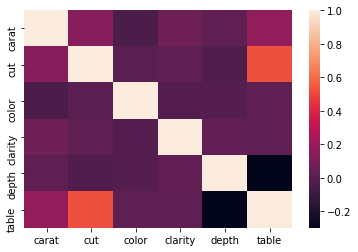

In [12]:
sns.heatmap(xcorr)

In [13]:
#Esto es para ver si en las variables pueden haber outliers
mean_depth = data.depth.mean()
var_depth = data.depth.var()
desvi_depth = np.std(data.depth)
coef_var = desvi_depth/mean_depth

In [14]:
#Con esta funncion busco las variables nno categoricas que puedan tener outliers
def variacion(x):
    mean = x.mean()
    desvi = np.std(x)
    coef = desvi/mean
    return coef


In [15]:
variacion(X.carat),variacion(X.depth), variacion(X.table)

(0.5929548092221981, 0.023173484725168947, 0.03891696830481638)

In [16]:
#Esta funcion me sirve para sacar los valores outliers 
def gimme_the_otliers_edu(s):
    outliers=[]
    for i in s:
        if i < (s.quantile(0.25)-1.5*(s.quantile(0.75)-s.quantile(0.25))):
                outliers.append(i)
        elif i > (s.quantile(0.75)+1.5*(s.quantile(0.75)-s.quantile(0.25))):
                outliers.append(i)
        
    return outliers

In [17]:
def gimme_the_otliers(s):
    Q1 = s.quantile(0.25)
    Q3 = s.quantile(0.75)
    IQR = Q3-Q1
    min_v = Q1 - (1.5 * IQR)
    max_v = Q3 + (1.5 * IQR)
    
    return [value for value in s if ((value < min_v) or (value>max_v))]

In [18]:
#gimme_the_otliers_edu(X.carat)
ou = gimme_the_otliers(X.carat)
suma_de_outliers  = 0
for i in ou:
    suma_de_outliers  += 1

print(f'hay un total de {suma_de_outliers} outliers')

hay un total de 1404 outliers


In [20]:
newX = X
newX.head()

,carat,cut,color,clarity,depth,table
0,1.14,1,1,1,61.0,56.0
1,0.76,1,2,2,62.7,57.0
2,0.84,1,1,3,61.4,56.0
3,1.55,1,2,3,62.0,57.0
4,0.30,1,1,4,61.9,57.0


In [21]:
for i in newX.carat:
    if i in ou:
        newX.carat.drop(i, axis = 0)

KeyError: '[2.03] not found in axis'

In [18]:
(suma_de_outliers/len(X.carat))*100

3.4705228031145716

<AxesSubplot:xlabel='carat'>

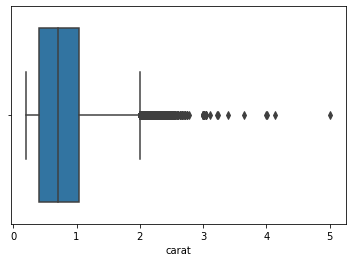

In [19]:
sns.boxplot(x = X.carat)

In [20]:
X.head()

,carat,cut,color,clarity,depth,table
0,1.14,1,1,1,61.0,56.0
1,0.76,1,2,2,62.7,57.0
2,0.84,1,1,3,61.4,56.0
3,1.55,1,2,3,62.0,57.0
4,0.30,1,1,4,61.9,57.0


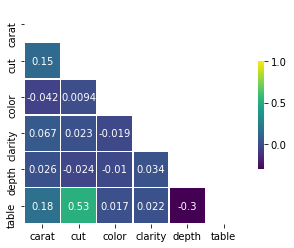

In [21]:
mascara = np.triu(np.ones_like(xcorr, dtype=bool)) # generamos la máscara para la triangular superior
color_map = sns.diverging_palette(0, 10, as_cmap=True) # paleta de colores
sns.heatmap(xcorr,
            mask = mascara,
            cmap='viridis',
            square=True, #que los datos se vean como cuadrados
            linewidth=0.5, #ancho de línea
            vmax=1,
            cbar_kws={"shrink": .5}, #barra lateral,
            annot=True
);

In [22]:
#X.to_csv('train_clean.csv')

In [24]:
#data_test.to_csv('test_clean.csv')